# H2O Automated Machine Learning (AutoML)

## 0 Introduction
The objective of this notbook is to use to data generated from the previous notebooks to carry out Automated Machine Learning (AutoML) and captrure the important features at the underlying structure of signal peptides. In order to achieve this, the predictions of SignalP algorithm will be merged with the observations of Proteomics results obtained from the previous two notebooks, respectively. This will enable the observed signal peptides to be assigned with peptide abundance, while keeping the predicted signal peptides at zero abundance, thus generating a dataframe that emphasizes importance of signal peptides through the peptide abundance. 

### Agenda
- Generate dataframe for AutoML
- Utilize AutoML to carry out ML operations
- Determine the best AutoML model generated
- Analyze the best model parameters 
- Check AutoML prediction based on the best model

In [19]:
def one_hot_encode_aa(df):
    """One-hot encode amino acid sequences in a pandas dataframe"""

    # Define amino acid alphabet
    aa_alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
                   'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']

    # Determine maximum sequence length in input dataframe
    max_seq_len = df.applymap(len).max().max()

    # Initialize one-hot encoding dataframe
    encoding_df = pd.DataFrame()

    # Loop over columns in input dataframe and encode each amino acid sequence
    for col in df.columns:
        # Extract amino acid sequences from current column
        seqs = df[col].values

        # Initialize 2D array to hold one-hot encoding for current column
        encoding_matrix = np.zeros((len(seqs), max_seq_len * len(aa_alphabet)))

        # Loop over amino acid sequences and one-hot encode each one
        for i, seq in enumerate(seqs):
            # Get one-hot encoding vector for current amino acid sequence
            encoding_vec = np.zeros((max_seq_len, len(aa_alphabet)))
            for j, aa in enumerate(seq):
                encoding_vec[j, aa_alphabet.index(aa)] = 1

            # Flatten encoding vector and add it to encoding matrix for current column
            encoding_matrix[i, :] = encoding_vec.flatten()

        # Convert encoding matrix to dataframe and add it to one-hot encoding dataframe
        col_encoding_df = pd.DataFrame(encoding_matrix)
        col_encoding_df.columns = [f'{col}_{j}' for j in range(max_seq_len * len(aa_alphabet))]
        encoding_df = pd.concat([encoding_df, col_encoding_df], axis=1)

    return encoding_df


def one_hot_decode_aa(df, max_length = 22):
    # Define amino acid alphabet
    aa_alphabet = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M',
                    'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '-']
    sps = []
    peptide = ''
    cols = list(df.columns)

    for index, row in df.iterrows():
        for col in cols: 
            if int(row[col]) ==1: 
                aa_index = int(col.split('_')[1])
                aa_acid = aa_alphabet[aa_index]
                peptide += aa_acid
                if len(peptide) == max_length: 
                    sps.append(peptide)
                    peptide = ''

    df['decoded_sequence'] = sps

    return df

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [21]:
#from google.colab import drive 
#drive.mount('/content/home')

## 1 ML dataframe generation

In [22]:
# Load the mean proteomcis dataset and common signal peptide dataset obtained from previous notebooks
#df_proteomcis_abundance_means = pd.read_csv('/content/home/MyDrive/DTU-MASTER/DTU-Sem4/Thesis/sigpep/Data/proteomics_mean_peptide_abundances.csv')
df_proteomcis_abundance_means = pd.read_csv('../data/03_proteomics_data/proteomics_mean_peptide_abundances.csv')
df_signalP_predictions = pd.read_excel('../data/02_all_signal_peptides/sigpep_predict.xlsx')

In [23]:
df_proteomcis_abundance_means

,Accession,MM mean abundances (Scaled),MM mean abundances (Scaled-Normalized),MM + Nitrogen mean abundances (Scaled),MM + Nitrogen mean abundances (Scaled-Normalized),MM mean abundances (Raw),MM mean abundances (Raw-Normalized),MM + Nitrogen mean abundances (Raw),MM + Nitrogen mean abundances (Raw-Normalized)
0,AO090003000935-T-p1,5.700000,0.059285,64.833333,0.059285,1.066262e+08,0.010224,1.494872e+09,0.417923
1,AO090023000944-T-p1,250.433333,0.044270,53.733333,0.044270,2.632887e+08,0.025062,7.327970e+07,0.017628
2,AO090003001591-T-p1,230.066667,0.058537,69.166667,0.058537,1.047763e+10,1.000000,4.066686e+09,1.000000
3,AO090005001300-T-p1,50.566667,0.080759,94.433333,0.080759,3.997800e+07,0.003882,9.707511e+07,0.024045
4,AO090010000746-T-p1,105.633333,0.228295,264.400000,0.228295,2.719032e+08,0.025872,8.634503e+08,0.218331
...,...,...,...,...,...,...,...,...,...
860,AO090001000075-T-p1,110.200000,0.254802,310.600000,0.254802,1.013201e+05,0.000010,3.909362e+05,0.000090
861,AO090005001355-T-p1,105.400000,0.122683,184.200000,0.122683,3.984604e+04,0.000003,9.575187e+04,0.000015
862,AO090003000247-T-p1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
863,AO090001000680-T-p1,NaN,0.309596,389.333333,0.309596,NaN,NaN,9.818556e+04,0.000019


In [24]:
df_signalP_predictions

,gene,start_pos,end_pos,signal_peptide_likelyhood,sequence
0,AO090005000016-T-p1,0,23,0.999803,MAPSHSFMLFLSVICTHLCSLVV
1,AO090005000029-T-p1,0,23,0.999835,MHLRNIVIALAATAVASPVDLQD
2,AO090005000042-T-p1,0,23,0.999843,MKASFISRLLSLTAFAISSNLSY
3,AO090005000053-T-p1,0,41,0.854809,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL
4,AO090005000059-T-p1,0,18,0.999821,MHLQATLAVGLSLLGLTL
...,...,...,...,...,...
1056,AO090103000483-T-p1,0,19,0.833106,MKTSFLLAAIGFLYRLPCS
1057,AO090103000487-T-p1,0,19,0.999710,MTRYLSFLFLLILFGNSVF
1058,AO090103000493-T-p1,0,17,0.999791,MRGIVALSFLSVALGVT
1059,AO090701000994-T-p1,0,18,0.999845,MRLLLIAPLFSAVSYGAQ


In [25]:
# Change the name to allow merge
df_signalP_predictions = df_signalP_predictions.rename(columns={'gene': 'Accession', 'end_pos': 'length'})

In [26]:
df_signalP_predictions

,Accession,start_pos,length,signal_peptide_likelyhood,sequence
0,AO090005000016-T-p1,0,23,0.999803,MAPSHSFMLFLSVICTHLCSLVV
1,AO090005000029-T-p1,0,23,0.999835,MHLRNIVIALAATAVASPVDLQD
2,AO090005000042-T-p1,0,23,0.999843,MKASFISRLLSLTAFAISSNLSY
3,AO090005000053-T-p1,0,41,0.854809,MGLFLTALGALSSVNVLYSRGRMPLKHLATLLCALSPTVAL
4,AO090005000059-T-p1,0,18,0.999821,MHLQATLAVGLSLLGLTL
...,...,...,...,...,...
1056,AO090103000483-T-p1,0,19,0.833106,MKTSFLLAAIGFLYRLPCS
1057,AO090103000487-T-p1,0,19,0.999710,MTRYLSFLFLLILFGNSVF
1058,AO090103000493-T-p1,0,17,0.999791,MRGIVALSFLSVALGVT
1059,AO090701000994-T-p1,0,18,0.999845,MRLLLIAPLFSAVSYGAQ


In [27]:
# Merge the dataframes
df_ML_signal_peptides = pd.merge(df_proteomcis_abundance_means, df_signalP_predictions, on='Accession', how='right')

# Set NaN values to zero
df_ML_signal_peptides.fillna(value=0, inplace=True)

# Create a new column that sorts the accession in a descending order to abundances observed in the raw data column
df_ML_signal_peptides['max_abundance'] = df_ML_signal_peptides[['MM mean abundances (Raw)', 'MM + Nitrogen mean abundances (Raw)']].max(axis=1)
df_ML_signal_peptides = df_ML_signal_peptides.sort_values(by='max_abundance', ascending=False)

df_ML_signal_peptides

,Accession,MM mean abundances (Scaled),MM mean abundances (Scaled-Normalized),MM + Nitrogen mean abundances (Scaled),MM + Nitrogen mean abundances (Scaled-Normalized),MM mean abundances (Raw),MM mean abundances (Raw-Normalized),MM + Nitrogen mean abundances (Raw),MM + Nitrogen mean abundances (Raw-Normalized),start_pos,length,signal_peptide_likelyhood,sequence,max_abundance
318,AO090003001591-T-p1,230.066667,0.058537,69.166667,0.058537,1.047763e+10,1.000000,4.066686e+09,1.000000,0,20,0.999866,MMVAWWSLFLYGLQVAAPAL,1.047763e+10
269,AO090003000935-T-p1,5.700000,0.059285,64.833333,0.059285,1.066262e+08,0.010224,1.494872e+09,0.417923,0,27,0.999834,MEAFNLHNFLSSLYILLPFVILANPVH,1.494872e+09
1020,AO090103000076-T-p1,0.700000,0.430035,472.900000,0.430035,1.496427e+06,0.000144,1.202415e+09,0.339312,0,18,0.999835,MLRVSAIFMACLLLATAA,1.202415e+09
401,AO090026000003-T-p1,0.833333,0.414383,470.100000,0.414383,1.498718e+06,0.000144,1.061096e+09,0.276919,0,24,0.848574,MAVRIARFLGLSTVAYLALANGID,1.061096e+09
1011,AO090010000746-T-p1,105.633333,0.228295,264.400000,0.228295,2.719032e+08,0.025872,8.634503e+08,0.218331,0,24,0.999747,MVSFSSCLRALALGSSVLAVQPVL,8.634503e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422,AO090026000252-T-p1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0,18,0.999834,MQVKLFYTLALWAPILVS,0.000000e+00
423,AO090026000257-T-p1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0,15,0.999809,MKSLIWALPFIPLAY,0.000000e+00
425,AO090026000367-T-p1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0,22,0.999847,MWPTRSLSSLFFLSLALGSPVS,0.000000e+00
427,AO090026000428-T-p1,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0,22,0.999792,MLLPRLSSLLCLAGLATMPVAN,0.000000e+00


In [28]:
# Change the name for simplicity
df_ML_signal_peptides  = df_ML_signal_peptides.rename(columns={'MM + Nitrogen mean abundances (Raw-Normalized)': 'abundance',})

# Isolate the desired columns from the dataframe
df_ML_signal_peptides = df_ML_signal_peptides[['sequence', 'length', 'abundance']]
df_ML_signal_peptides

,sequence,length,abundance
318,MMVAWWSLFLYGLQVAAPAL,20,1.000000
269,MEAFNLHNFLSSLYILLPFVILANPVH,27,0.417923
1020,MLRVSAIFMACLLLATAA,18,0.339312
401,MAVRIARFLGLSTVAYLALANGID,24,0.276919
1011,MVSFSSCLRALALGSSVLAVQPVL,24,0.218331
...,...,...,...
422,MQVKLFYTLALWAPILVS,18,0.000000
423,MKSLIWALPFIPLAY,15,0.000000
425,MWPTRSLSSLFFLSLALGSPVS,22,0.000000
427,MLLPRLSSLLCLAGLATMPVAN,22,0.000000


In [29]:
# Convert and save a summary dataframe
ml_save = True # change this to save the dataframe
if ml_save:
  df_ML_signal_peptides.to_csv('../data/03_proteomics_data/ML_signal_peptides.csv', index=False)

## 2 Data preparation for H2O AutoML

In [30]:
# Load the dataframe generated in the previous notebook for AutoML operations
df_signalPP = pd.read_csv('../data/03_proteomics_data/ML_signal_peptides.csv')
df_signalPP

,sequence,length,abundance
0,MMVAWWSLFLYGLQVAAPAL,20,1.000000
1,MEAFNLHNFLSSLYILLPFVILANPVH,27,0.417923
2,MLRVSAIFMACLLLATAA,18,0.339312
3,MAVRIARFLGLSTVAYLALANGID,24,0.276919
4,MVSFSSCLRALALGSSVLAVQPVL,24,0.218331
...,...,...,...
1056,MQVKLFYTLALWAPILVS,18,0.000000
1057,MKSLIWALPFIPLAY,15,0.000000
1058,MWPTRSLSSLFFLSLALGSPVS,22,0.000000
1059,MLLPRLSSLLCLAGLATMPVAN,22,0.000000


In [31]:
# Select only rows where "length" column is 22 or smaller
df_signalPP_filtered = df_signalPP[df_signalPP["length"] <= 22]
df_signalPP_filtered = df_signalPP_filtered.reset_index()
df_signalPP_filtered

,index,sequence,length,abundance
0,0,MMVAWWSLFLYGLQVAAPAL,20,1.000000
1,2,MLRVSAIFMACLLLATAA,18,0.339312
2,6,MRFSAIFTLGLAGTALATPLVE,22,0.119362
3,7,MMVAWWSLFLYGLQVAAPAL,20,0.017628
4,8,MHLPTLVTLACMAVSAS,17,0.071338
...,...,...,...,...
730,1056,MQVKLFYTLALWAPILVS,18,0.000000
731,1057,MKSLIWALPFIPLAY,15,0.000000
732,1058,MWPTRSLSSLFFLSLALGSPVS,22,0.000000
733,1059,MLLPRLSSLLCLAGLATMPVAN,22,0.000000


In [32]:
describe = df_signalPP_filtered["sequence"].describe()
describe 


count                      735
unique                     733
top       MMVAWWSLFLYGLQVAAPAL
freq                         3
Name: sequence, dtype: object

In [33]:
describe = df_signalPP_filtered["length"].describe()
describe

count    735.000000
mean      18.423129
std        2.120166
min       12.000000
25%       17.000000
50%       18.000000
75%       20.000000
max       22.000000
Name: length, dtype: float64

In [34]:
describe = df_signalPP_filtered["abundance"].describe()
describe

count    735.000000
mean       0.002818
std        0.039385
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: abundance, dtype: float64

Lets split each amino acid of the signal peptides into a separte column by using an algorithm

In [35]:
def split_peptides_sequences(df_signalPP_filtered:pd.DataFrame): 
    '''Split each AA for each position'''
    peptides_split = []
    for k,v in df_signalPP_filtered.iterrows(): 
        sequence = []
        for seq in v['sequence']: 
            sequence.append(seq)
        peptides_split.append(sequence)
    
    # make a dataframe
    new_peptides = pd.DataFrame(peptides_split)
    new_peptides = new_peptides.fillna('-')

    return new_peptides

In [36]:
df_signalPP_split = split_peptides_sequences(df_signalPP_filtered)
df_signalPP_split

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,M,M,V,A,W,W,S,L,F,L,...,L,Q,V,A,A,P,A,L,-,-
1,M,L,R,V,S,A,I,F,M,A,...,L,L,A,T,A,A,-,-,-,-
2,M,R,F,S,A,I,F,T,L,G,...,G,T,A,L,A,T,P,L,V,E
3,M,M,V,A,W,W,S,L,F,L,...,L,Q,V,A,A,P,A,L,-,-
4,M,H,L,P,T,L,V,T,L,A,...,A,V,S,A,S,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,M,Q,V,K,L,F,Y,T,L,A,...,A,P,I,L,V,S,-,-,-,-
731,M,K,S,L,I,W,A,L,P,F,...,L,A,Y,-,-,-,-,-,-,-
732,M,W,P,T,R,S,L,S,S,L,...,L,S,L,A,L,G,S,P,V,S
733,M,L,L,P,R,L,S,S,L,L,...,A,G,L,A,T,M,P,V,A,N


### One-hot encode the signal peptides 

In [37]:
df_signalPP_split = one_hot_encode_aa(df_signalPP_split)
feature_cols = df_signalPP_split.columns
df_signalPP_split

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,21_11,21_12,21_13,21_14,21_15,21_16,21_17,21_18,21_19,21_20
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
# Merge the experimental abundances with the split dataframe
df_signalPP_split['abundance'] = df_signalPP_filtered['abundance']
df_signalPP_split

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,21_12,21_13,21_14,21_15,21_16,21_17,21_18,21_19,21_20,abundance
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.339312
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119362
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.017628
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.071338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
732,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## 3 H2O AutoML

In [41]:
%%capture 
!pip install h2o 

In [42]:
# Import the required packages for H2O AutoML operations 
import h2o
from h2o.automl import H2OAutoML

In [43]:
# Initiate H2O
h2o.init(ip="localhost", min_mem_size_GB=8)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_361"; Java(TM) SE Runtime Environment (build 1.8.0_361-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.361-b09, mixed mode)
  Starting server from /Users/lucaslevassor/opt/anaconda3/envs/constrain/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmprta1f0mu
  JVM stdout: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmprta1f0mu/h2o_lucaslevassor_started_from_python.out
  JVM stderr: /var/folders/2f/lw3sfzbs7l7f_q1knzbtbwrr0000gp/T/tmprta1f0mu/h2o_lucaslevassor_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,21 secs
H2O_cluster_timezone:,Europe/Copenhagen
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,2 months and 17 days
H2O_cluster_name:,H2O_from_python_lucaslevassor_e9pj55
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.576 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [44]:
# Convert the split dataframe into H2O datafame (H2OFrame)
df_test = h2o.H2OFrame(df_signalPP_split)
df_test.describe()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


Rows:735
Cols:463

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,0_10,0_11,0_12,0_13,0_14,0_15,0_16,0_17,0_18,0_19,0_20,1_0,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,1_9,1_10,1_11,1_12,1_13,1_14,1_15,1_16,1_17,1_18,1_19,1_20,2_0,2_1,2_2,2_3,2_4,2_5,2_6,2_7,2_8,2_9,2_10,2_11,2_12,2_13,2_14,2_15,2_16,2_17,2_18,2_19,2_20,3_0,3_1,3_2,3_3,3_4,3_5,3_6,3_7,3_8,3_9,3_10,3_11,3_12,3_13,3_14,3_15,3_16,3_17,3_18,3_19,3_20,4_0,4_1,4_2,4_3,4_4,4_5,4_6,4_7,4_8,4_9,4_10,4_11,4_12,4_13,4_14,4_15,4_16,4_17,4_18,4_19,4_20,5_0,5_1,5_2,5_3,5_4,5_5,5_6,5_7,5_8,5_9,5_10,5_11,5_12,5_13,5_14,5_15,5_16,5_17,5_18,5_19,5_20,6_0,6_1,6_2,6_3,6_4,6_5,6_6,6_7,6_8,6_9,6_10,6_11,6_12,6_13,6_14,6_15,6_16,6_17,6_18,6_19,6_20,7_0,7_1,7_2,7_3,7_4,7_5,7_6,7_7,7_8,7_9,7_10,7_11,7_12,7_13,7_14,7_15,7_16,7_17,7_18,7_19,7_20,8_0,8_1,8_2,8_3,8_4,8_5,8_6,8_7,8_8,8_9,8_10,8_11,8_12,8_13,8_14,8_15,8_16,8_17,8_18,8_19,8_20,9_0,9_1,9_2,9_3,9_4,9_5,9_6,9_7,9_8,9_9,9_10,9_11,9_12,9_13,9_14,9_15,9_16,9_17,9_18,9_19,9_20,10_0,10_1,10_2,10_3,10_4,10_5,10_6,10_7,10_8,10_9,10_10,10_11,10_12,10_13,10_14,10_15,10_16,10_17,10_18,10_19,10_20,11_0,11_1,11_2,11_3,11_4,11_5,11_6,11_7,11_8,11_9,11_10,11_11,11_12,11_13,11_14,11_15,11_16,11_17,11_18,11_19,11_20,12_0,12_1,12_2,12_3,12_4,12_5,12_6,12_7,12_8,12_9,12_10,12_11,12_12,12_13,12_14,12_15,12_16,12_17,12_18,12_19,12_20,13_0,13_1,13_2,13_3,13_4,13_5,13_6,13_7,13_8,13_9,13_10,13_11,13_12,13_13,13_14,13_15,13_16,13_17,13_18,13_19,13_20,14_0,14_1,14_2,14_3,14_4,14_5,14_6,14_7,14_8,14_9,14_10,14_11,14_12,14_13,14_14,14_15,14_16,14_17,14_18,14_19,14_20,15_0,15_1,15_2,15_3,15_4,15_5,15_6,15_7,15_8,15_9,15_10,15_11,15_12,15_13,15_14,15_15,15_16,15_17,15_18,15_19,15_20,16_0,16_1,16_2,16_3,16_4,16_5,16_6,16_7,16_8,16_9,16_10,16_11,16_12,16_13,16_14,16_15,16_16,16_17,16_18,16_19,16_20,17_0,17_1,17_2,17_3,17_4,17_5,17_6,17_7,17_8,17_9,17_10,17_11,17_12,17_13,17_14,17_15,17_16,17_17,17_18,17_19,17_20,18_0,18_1,18_2,18_3,18_4,18_5,18_6,18_7,18_8,18_9,18_10,18_11,18_12,18_13,18_14,18_15,18_16,18_17,18_18,18_19,18_20,19_0,19_1,19_2,19_3,19_4,19_5,19_6,19_7,19_8,19_9,19_10,19_11,19_12,19_13,19_14,19_15,19_16,19_17,19_18,19_19,19_20,20_0,20_1,20_2,20_3,20_4,20_5,20_6,20_7,20_8,20_9,20_10,20_11,20_12,20_13,20_14,20_15,20_16,20_17,20_18,20_19,20_20,21_0,21_1,21_2,21_3,21_4,21_5,21_6,21_7,21_8,21_9,21_10,21_11,21_12,21_13,21_14,21_15,21_16,21_17,21_18,21_19,21_20,abundance
type,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,in

Lets set arguments and train an AutoML. However, before we do that, it is important to emphasize that the validation of the models is aimed to be done internally by using K-fold cross-validation to avoid data sacrifice and statistical issues with the validation split. 

Hence, once the models are generated, the validation of the best models will be done by checking the cross-validation metrics to confirm the stability of the model estimations. 

More information: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html

In [45]:
# Select the columns we want to train on
feature_cols = list(feature_cols)

# Initialize H2O autoML class
AutoML = H2OAutoML(
    max_runtime_secs = 0,  # 1 hour = int(3600 * 1), (max_runtime_secs=0 sets for unlimited time)
    max_models = None,     # None =  no limit in the number of model generation
    nfolds = 10,           # Number of folds for k-fold cross-validation (nfolds == 0 disables cross-validation)
    seed = 1,              # Reproducibility
    sort_metric = "MAE",   # Metric to be used for the sorting of the models generated
    keep_cross_validation_predictions = True,  # Hold corss-validation predictions
    #include_algos = ["DeepLearning"]    # Include only DeepLearning
    )

In [46]:
# Set this varibale equal to "True" if you want to train a new model
train = True

In [47]:
%%time
if train:
  # Train the AutoML model
  AutoML.train(
      x = feature_cols,
      y = 'abundance',
      training_frame = df_test,
      )   

AutoML progress: |
09:04:34.532: _train param, Dropping bad and constant columns: [0_19, 0_18, 0_17, 0_16, 0_15, 10_3, 0_14, 10_2, 0_13, 0_12, 10_11, 10_14, 12_8, 10_8, 5_20, 10_20, 0_11, 0_10, 1_20, 9_20, 1_1, 1_3, 3_2, 5_3, 13_14, 9_2, 9_3, 4_20, 0_20, 8_20, 11_3, 11_2, 21_10, 11_8, 3_20, 7_20, 0_0, 0_1, 0_2, 0_3, 20_4, 0_4, 0_5, 0_6, 0_7, 0_8, 6_2, 0_9, 8_2, 8_3, 2_20, 11_20, 6_20]

█
09:04:39.928: _train param, Dropping bad and constant columns: [0_19, 0_18, 0_17, 0_16, 0_15, 10_3, 0_14, 10_2, 0_13, 0_12, 10_11, 10_14, 12_8, 10_8, 5_20, 10_20, 0_11, 0_10, 1_20, 9_20, 1_1, 1_3, 3_2, 5_3, 13_14, 9_2, 9_3, 4_20, 0_20, 8_20, 11_3, 11_2, 21_10, 11_8, 3_20, 7_20, 0_0, 0_1, 0_2, 0_3, 20_4, 0_4, 0_5, 0_6, 0_7, 0_8, 6_2, 0_9, 8_2, 8_3, 2_20, 11_20, 6_20]

█
09:04:42.456: _train param, Dropping bad and constant columns: [0_19, 0_18, 0_17, 0_16, 0_15, 10_3, 0_14, 10_2, 0_13, 0_12, 10_11, 10_14, 12_8, 10_8, 5_20, 10_20, 0_11, 0_10, 1_20, 9_20, 1_1, 1_3, 3_2, 5_3, 13_14, 9_2, 9_3, 4_20, 0_20, 8

In [48]:
# View the AutoML Leaderboard
leaderboard = AutoML.leaderboard
leaderboard.head(rows=leaderboard.nrows)  # Print all rows instead of default (10 rows)

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
DeepLearning_grid_1_AutoML_1_20230426_90434_model_9,0.00378364,0.0389053,0.00151363,0.0278937,0.00151363
DeepLearning_grid_1_AutoML_1_20230426_90434_model_6,0.00425797,0.0387425,0.00150098,0.027776,0.00150098
DeepLearning_grid_1_AutoML_1_20230426_90434_model_4,0.00447344,0.0388417,0.00150868,0.0278706,0.00150868
DeepLearning_grid_1_AutoML_1_20230426_90434_model_13,0.0046658,0.0387894,0.00150462,0.0278477,0.00150462
GBM_grid_1_AutoML_1_20230426_90434_model_67,0.00469561,0.0393566,0.00154895,0.0283128,0.00154895
GBM_grid_1_AutoML_1_20230426_90434_model_77,0.00481867,0.0433117,0.0018759,0.0322319,0.0018759
GBM_grid_1_AutoML_1_20230426_90434_model_89,0.00484406,0.03969,0.00157529,0.0287549,0.00157529
GBM_grid_1_AutoML_1_20230426_90434_model_51,0.00492936,0.0396317,0.00157067,0.0286872,0.00157067
GBM_grid_1_AutoML_1_20230426_90434_model_19,0.00496522,0.0393679,0.00154983,0.0283357,0.00154983
DRF_1_AutoML_1_20230426_90434,0.00496764,0.0444701,0.00197759,0.0332197,0.00197759


In [49]:
# Select the model performed the best according to the sorting metric
best_model = AutoML.get_best_model()
best_model_name = best_model.key

In [ ]:
best_model_name

'DeepLearning_grid_1_AutoML_1_20230311_144817_model_11'

In [50]:
# Save the beset model
out_path = '../data/04_ML_models'
mdl = h2o.get_model(best_model_name)
h2o.save_model(model=mdl, path=out_path, force=True)

'/Users/lucaslevassor/projects/Signal_peptide_project/data/04_ML_models/DeepLearning_grid_1_AutoML_1_20230426_90434_model_9'

In [53]:
# Save the leaderboard ids
out_path = '../data/04_ML_models/leaderboards/DeepLearning_grid_1_AutoML_1_20230426_90434_model_9'
h2o.export_file(leaderboard, path=out_path, force=True)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


## 4 AutoML model analysis

In [54]:
# Import the leaderboard from the AutoML training
lb = h2o.import_file("../data/04_ML_models/leaderboards/DeepLearning_grid_1_AutoML_1_20230426_90434_model_9")
print(lb)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     mae       rmse         mse      rmsle    mean_residual_deviance
DeepLearning_grid_1_AutoML_1_20230426_90434_model_9   0.00378364  0.0389053  0.00151363  0.0278937                0.00151363
DeepLearning_grid_1_AutoML_1_20230426_90434_model_6   0.00425797  0.0387425  0.00150098  0.027776                 0.00150098
DeepLearning_grid_1_AutoML_1_20230426_90434_model_4   0.00447344  0.0388417  0.00150868  0.0278706                0.00150868
DeepLearning_grid_1_AutoML_1_20230426_90434_model_13  0.0046658   0.0387894  0.00150462  0.0278477                0.00150462
GBM_grid_1_AutoML_1_20230426_90434_model_67           0.00469561  0.0393566  0.00154895  0.0283128                0.00154895
GBM_grid_1_AutoML_1_20230426_90434_model_77           0.00481867  0.0433117  0.0018759   0.0322319                0.0018759
GBM_grid_1_AutoML_1_20230426_90

In [55]:
# Import the best model obtained from AutoML training
best_model = h2o.load_model("../data/04_ML_models/DeepLearning_grid_1_AutoML_1_20230426_90434_model_9")
print(best_model)

Model Details
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning_grid_1_AutoML_1_20230426_90434_model_9


Status of Neuron Layers: predicting abundance, regression, gaussian distribution, Quadratic loss, 8,221 weights/biases, 143.7 KB, 1,176,000 training samples, mini-batch size 1
    layer    units    type              dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight           weight_rms            mean_bias            bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  ---------------------  ----------  --------------------  --------------------  -------------------  -----------------------
    1        409      Input             0.0
    2        20       RectifierDropout  10.0       0.0   0.0   0.06183238344844711    0.09828370809555054    0.0         0.0686823157126141    0.3475421667098999    -0.6929061269026185  0.42695140838623047
    3        1        Linear                     

Use the ".model_performance()" method to get the model performance metrics obtainde against the validatation dataset. By default, this method returns the metrics based on the training data, hence we need to set the x validation argument for the model performance as "True" (i.e., model_performance(xval=True)) to get the metrics based on the validation data

In [56]:
# Retrieve model performance
bm_performance = best_model.model_performance()
print(bm_performance)

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 0.0013813254682343238
RMSE: 0.03716618716298894
MAE: 0.004519562342447943
RMSLE: 0.02605423705509127
Mean Residual Deviance: 0.0013813254682343238


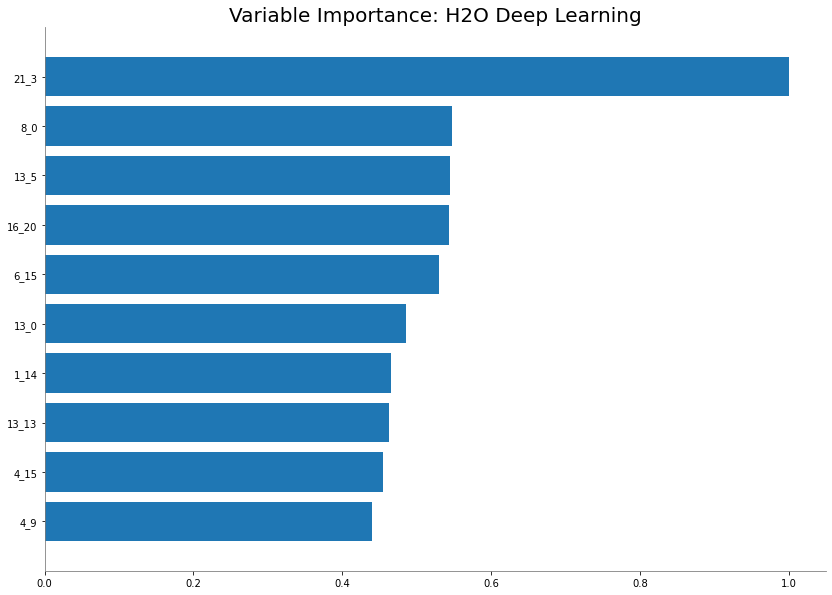

<Figure size 432x288 with 0 Axes>

In [57]:
best_model.varimp_plot()

In [58]:
# Retrieve the stored cross-validation (cv) holdout predictions
cv_hold_predictions = best_model.predict(df_test).as_data_frame()
cv_hold_predictions

deeplearning prediction progress: |██████████████████████████████████████████████| (done) 100%


,predict
0,0.045668
1,0.039686
2,0.112585
3,0.045668
4,0.023375
...,...
730,0.005663
731,0.001465
732,0.000449
733,0.004467


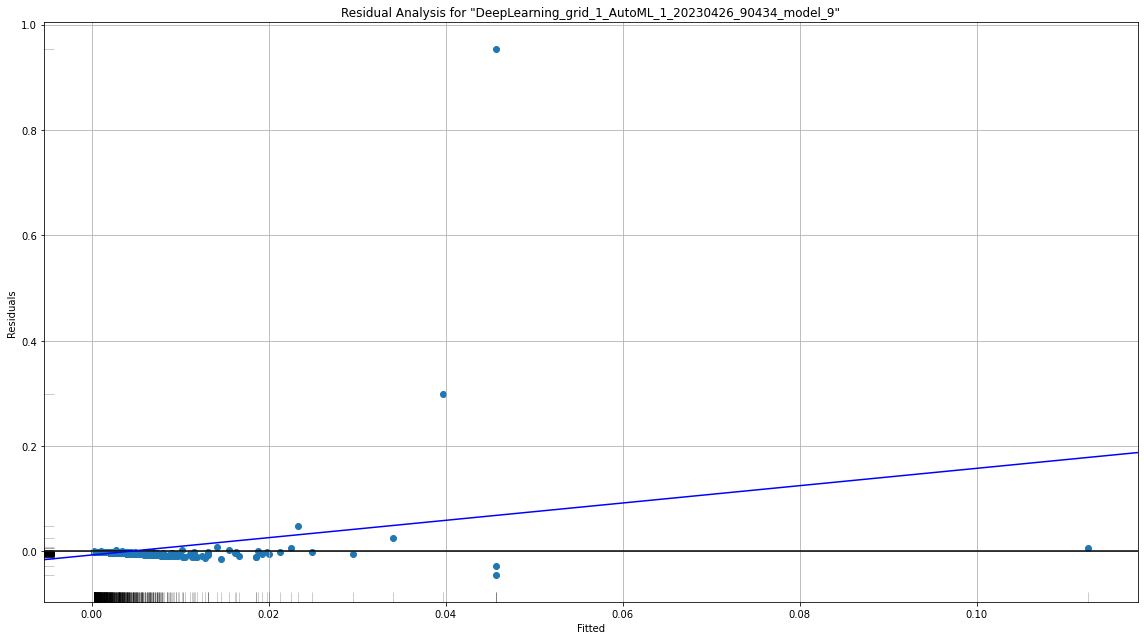

In [59]:
best_model.residual_analysis_plot(df_test)

In [60]:
# Convert df_test into a dataframe
df_test_as_df = df_test.as_data_frame()
df_test_as_df

,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,0_9,...,21_12,21_13,21_14,21_15,21_16,21_17,21_18,21_19,21_20,abundance
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.000000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.339312
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.119362
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.017628
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.071338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.000000
731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.000000
732,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0.000000
733,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000


In [61]:
# Merge the cv holdout predictions together with the df_test abundance
df_signalP_cv_holdout = pd.merge(df_test_as_df, cv_hold_predictions, left_index=True, right_index=True)

# Order the dataframe in the descending order of abundance values
df_signalP_cv_holdout = df_signalP_cv_holdout.sort_values(by= 'abundance', ascending = False)

# Rename the predict column
df_signalP_cv_holdout = df_signalP_cv_holdout.rename(columns={'predict': 'cv_hold_predictions'})

# Reset the indexing of the dataframe
df_signalP_cv_holdout = df_signalP_cv_holdout.reset_index()


In [62]:
# Generate percentage ranking of the abundance and cv_predictions 
df_signalP_cv_holdout['abundance_ranked_pct'] = df_signalP_cv_holdout['abundance'].rank(pct=True)
df_signalP_cv_holdout['cv_ranked_pct'] = df_signalP_cv_holdout['cv_hold_predictions'].rank(pct=True)
df_signalP_cv_holdout

,index,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,21_15,21_16,21_17,21_18,21_19,21_20,abundance,cv_hold_predictions,abundance_ranked_pct,cv_ranked_pct
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1.000000,0.045668,1.000000,0.997279
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.339312,0.039686,0.998639,0.994558
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.119362,0.112585,0.997279,1.000000
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.071338,0.023375,0.995918,0.989116
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.060200,0.034012,0.994558,0.993197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,354,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.000000,0.001273,0.380952,0.321088
731,353,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.000000,0.002691,0.380952,0.579592
732,352,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.000000,0.000909,0.380952,0.236735
733,351,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.000000,0.000975,0.380952,0.254422


In [64]:
# Save the dataframe
df_signalP_cv_holdout.to_csv('../data/04_ML_models/cv_holdout_pred/DeepLearning_grid_1_AutoML_1_20230426_90434_model_9.csv')

## 5 Visualization of AutoML model

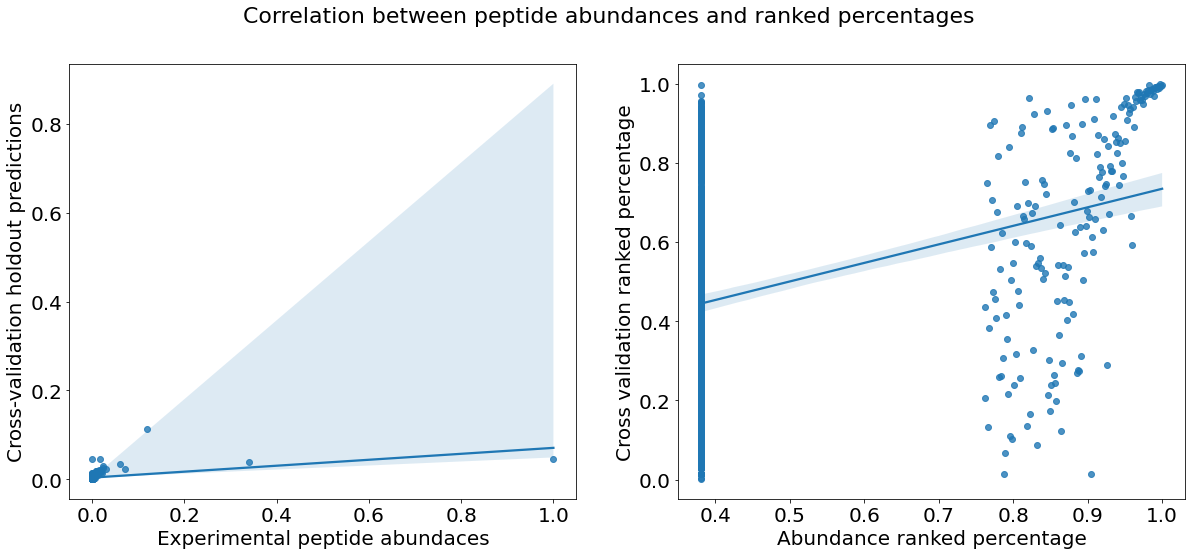

In [65]:
# Set the font size before creating any plot elements
plt.rc('font', size=20)

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
fig.suptitle('Correlation between peptide abundances and ranked percentages', fontsize=22)

# Left subplot
sns.regplot(x='abundance',y='cv_hold_predictions', data=df_signalP_cv_holdout, ax=axs[0])
axs[0].set_xlabel('Experimental peptide abundaces')
axs[0].set_ylabel('Cross-validation holdout predictions')

# Right subplot
sns.regplot(x='abundance_ranked_pct', y='cv_ranked_pct', data=df_signalP_cv_holdout, ax=axs[1])
axs[1].set_xlabel('Abundance ranked percentage')
axs[1].set_ylabel('Cross validation ranked percentage')

plt.show()

In [66]:
# Drop rows where NaN values of the peptide abundance was set to 0 to reduce noise (i.e. create a dataframe without (wo) NaN/zero values)
df_signalP_cv_holdout_wo_NaNs = df_signalP_cv_holdout[df_signalP_cv_holdout['abundance'] != 0]
df_signalP_cv_holdout_wo_NaNs

,index,0_0,0_1,0_2,0_3,0_4,0_5,0_6,0_7,0_8,...,21_15,21_16,21_17,21_18,21_19,21_20,abundance,cv_hold_predictions,abundance_ranked_pct,cv_ranked_pct
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1.000000,0.045668,1.000000,0.997279
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.339312,0.039686,0.998639,0.994558
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.119362,0.112585,0.997279,1.000000
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.071338,0.023375,0.995918,0.989116
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.060200,0.034012,0.994558,0.993197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,179,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.000005,0.001558,0.767347,0.383673
172,172,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.000003,0.000567,0.765986,0.133333
173,148,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.000003,0.004167,0.764626,0.749660
174,89,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0.000002,0.001734,0.762585,0.435374


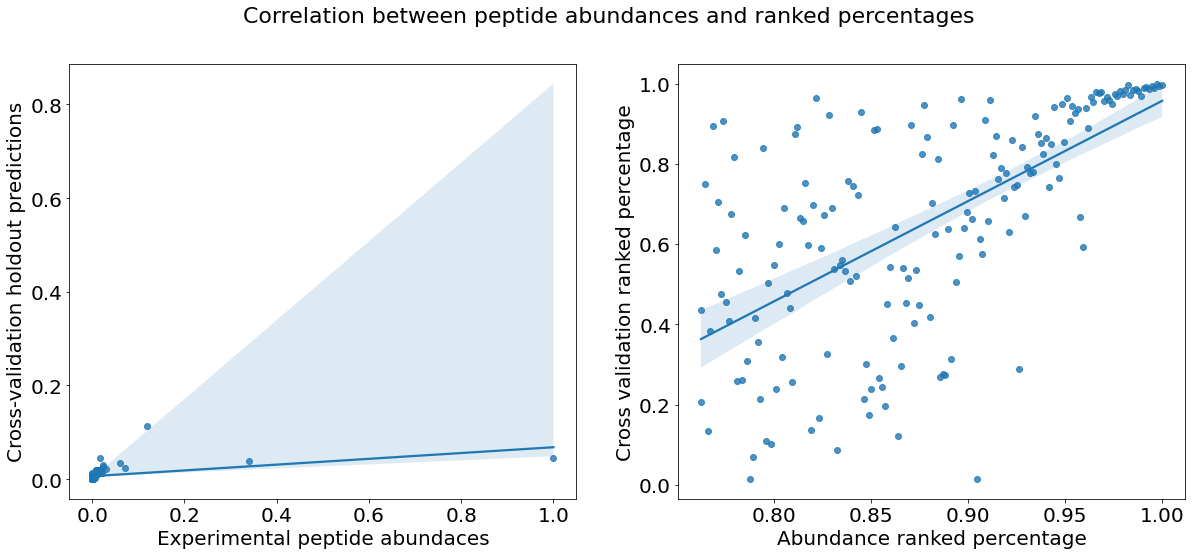

In [67]:
# Set the font size before creating any plot elements
plt.rc('font', size=20)

# Create a figure with 2 subplots side by side
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))
fig.suptitle('Correlation between peptide abundances and ranked percentages', fontsize=22)

# Left subplot
sns.regplot(x='abundance',y='cv_hold_predictions', data=df_signalP_cv_holdout_wo_NaNs, ax=axs[0])
axs[0].set_xlabel('Experimental peptide abundaces')
axs[0].set_ylabel('Cross-validation holdout predictions')

# Right subplot
sns.regplot(x='abundance_ranked_pct', y='cv_ranked_pct', data=df_signalP_cv_holdout_wo_NaNs, ax=axs[1])
axs[1].set_xlabel('Abundance ranked percentage')
axs[1].set_ylabel('Cross validation ranked percentage')

plt.show()

In [ ]:
# Save the resulting dataframe
df_signalP_cv_holdout_wo_NaNs.to_csv('/content/home/MyDrive/DTU-MASTER/DTU-Sem4/Thesis/sigpep/Data/06_H2O_AutoML/06.3_Cv_holdout_predictions/Second_round/m22_filtered_DeepLearning_grid_1_AutoML_1_20230311_144817_model_11_cv_hold_ranked_pct_wo_zeros.csv', index=False)